In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
from datetime import timedelta
import datetime
import math
from sklearn import model_selection
# from sklearn import proprocessing
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

In [73]:
train_missing=pd.read_csv('./train_xgb.csv')
test_missing= pd.read_csv('./test_xgb.csv')

train_copy = train_missing

test_for_id_only = pd.read_csv('../Data/test_lonlat_id_CS_0521_feature.csv')

test_id = test_for_id_only.id

In [74]:
# test_id

### 1m 2m Investment isolation

In [75]:
# print train_missing.shape
# train_1m      = train_missing.loc[(train_missing.price_doc==1000000),:]
# train_missing = train_missing.loc[-(train_missing.price_doc==1000000),:]

# print train_missing.shape
# train_2m      = train_missing.loc[(train_missing.price_doc==1000000),:]
# train_missing = train_missing.loc[-(train_missing.price_doc==2000000),:]
# train_missing.shape

In [76]:
print train_missing.shape
train_1m_2m   = train_missing.loc[(train_missing.price_doc==1000000)|(train_missing.price_doc==2000000),:]
train_missing = train_missing.loc[-((train_missing.price_doc==1000000)|(train_missing.price_doc==2000000)),:]

print train_missing.shape
# train_2m      = train_missing.loc[(train_missing.price_doc==1000000),:]
# train_missing = train_missing.loc[-(train_missing.price_doc==2000000),:]
# train_missing.shape

(30471, 43)
(28967, 43)


In [77]:
train_missing['price_full_sq'] = (train_missing['price_doc']/train_missing['full_sq'].astype(float)).astype(int)
train_1m_2m['price_full_sq']   = (train_1m_2m['price_doc']/train_1m_2m['full_sq'].astype(float)).astype(int)
y_train_missing = train_missing['price_full_sq']

/Users/chao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/chao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [78]:
x_train_missing = train_missing.drop(['price_full_sq','price_doc','id','timestamp'],axis=1)
x_train_1m_2m   = train_1m_2m.drop(['price_full_sq','price_doc','id','timestamp'],axis=1)
x_test_missing  = test_missing.drop(['id','timestamp'],axis=1)

In [84]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}



x_train_missing_subset = x_train_missing
x_train_1m_2m_subset   = x_train_1m_2m
x_test_missing_subset  = x_test_missing

dtrain_subset       = xgb.DMatrix(x_train_missing_subset, y_train_missing)
dtrain_1m_2m_subset =  xgb.DMatrix(x_train_1m_2m_subset)  # this is the 1m 2m loc
dtest_subset =  xgb.DMatrix(x_test_missing_subset)

cv_output = xgb.cv(xgb_params, dtrain_subset, 
                       num_boost_round=1000, 
                       early_stopping_rounds=20,
                       verbose_eval=50, show_stdv=False)
test_rmse = cv_output.loc[len(cv_output)-1,'test-rmse-mean']
print(test_rmse)


[0]	train-rmse:140678	test-rmse:140706
[50]	train-rmse:34783.7	test-rmse:36715.6
[100]	train-rmse:30590.3	test-rmse:33776.4
[150]	train-rmse:29087	test-rmse:33168.4
[200]	train-rmse:27888.2	test-rmse:32816.2
[250]	train-rmse:26854.2	test-rmse:32575.4
[300]	train-rmse:26009.8	test-rmse:32438.9
[350]	train-rmse:25249.8	test-rmse:32362.1
[400]	train-rmse:24528.8	test-rmse:32305.8
[450]	train-rmse:23873.5	test-rmse:32274.1
[500]	train-rmse:23243.1	test-rmse:32230.9
32211.2929687


In [80]:
num_boost_rounds= len(cv_output)
print(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain_subset, num_boost_round= num_boost_rounds)
print('Finish XGBoost training')

     test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0     140705.854167     820.474086    140678.213542      408.832376
1     134226.531250     816.120428    134179.354167      415.626004
2     128102.986979     832.380519    128033.382812      409.300271
3     122327.765625     854.531795    122241.140625      403.600657
4     116849.255208     862.538059    116735.218750      396.021145
5     111655.122396     881.381002    111522.044271      385.069998
6     106745.078125     887.251865    106583.763021      385.072588
7     102125.934896     898.736979    101933.731771      382.401722
8      97758.552083     923.197629     97533.570313      369.267328
9      93634.473958     934.468350     93377.684896      369.807786
10     89722.497396     955.795700     89440.609375      366.782076
11     86038.898438     970.567330     85730.760417      369.973523
12     82586.677083    1011.622008     82250.885417      338.419684
13     79324.117187    1025.655770     78958.286

### predict price for the original 1m 2m 'Investment' listings

In [86]:
y_train_1m_2m.shape

(1504,)

In [85]:
y_train_1m_2m = model.predict(dtrain_1m_2m_subset)
y_train_1m_2m_all_sq = (y_train_1m_2m)*x_train_1m_2m['full_sq']

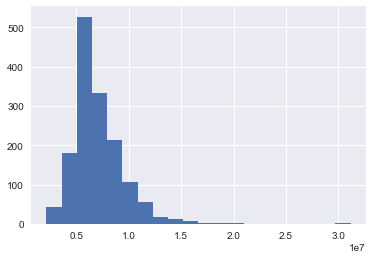

In [90]:
y_train_1m_2m_all_sq.hist(bins=20)

### now put the recalculated price back 

In [92]:
train_copy.loc[(train_copy.price_doc==1000000)|(train_copy.price_doc==2000000),'price_doc'] = y_train_1m_2m_all_sq

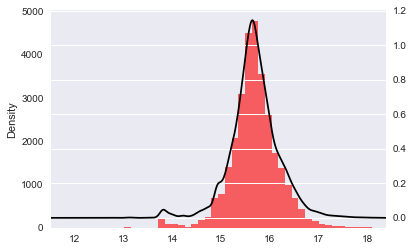

In [95]:
import visualization as vis
vis.hist_density_plot(train_copy, x='price_doc', logx=True)

In [96]:
train_copy.to_csv('train_xgb_1m_2m_repredicted.csv')

### now retrain with new data (1m 2m listings repredicted)

In [97]:
train2 = train_cofpy

train2['price_full_sq'] = (train2['price_doc']/train2['full_sq'].astype(float)).astype(int)
y_train2 = train2['price_full_sq']

In [99]:
x_train2 = train2.drop(['price_full_sq','price_doc','id','timestamp'],axis=1)

In [100]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}



x_train_missing_subset = x_train2
x_test_missing_subset  = x_test_missing

dtrain_subset = xgb.DMatrix(x_train_missing_subset, y_train2)
dtest_subset  = xgb.DMatrix(x_test_missing_subset)

cv_output = xgb.cv(xgb_params, dtrain_subset, 
                       num_boost_round=1000, 
                       early_stopping_rounds=20,
                       verbose_eval=50, show_stdv=False)
test_rmse = cv_output.loc[len(cv_output)-1,'test-rmse-mean']
print(test_rmse)

[0]	train-rmse:140981	test-rmse:140994
[50]	train-rmse:34251.2	test-rmse:35941.9
[100]	train-rmse:30050	test-rmse:32801.7
[150]	train-rmse:28599.8	test-rmse:32154.5
[200]	train-rmse:27399.4	test-rmse:31750.3
[250]	train-rmse:26422.6	test-rmse:31510.6
[300]	train-rmse:25607.3	test-rmse:31344.6
[350]	train-rmse:24876.4	test-rmse:31232.2
[400]	train-rmse:24185.2	test-rmse:31136.4
[450]	train-rmse:23558.1	test-rmse:31074.5
[500]	train-rmse:22935.8	test-rmse:31041.1
[550]	train-rmse:22363.4	test-rmse:31024.8
[600]	train-rmse:21852.3	test-rmse:30992.8
[650]	train-rmse:21363.1	test-rmse:30979
[700]	train-rmse:20907.6	test-rmse:30979
30971.6621093


In [103]:
num_boost_rounds= len(cv_output)
print(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain_subset, num_boost_round= num_boost_rounds)
print('Finish XGBoost training')

     test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0     140993.739583     508.160141    140980.885417      255.730464
1     134486.468750     530.298774    134456.151042      246.938125
2     128337.697917     535.583943    128288.382813      256.297511
3     122497.377604     553.211963    122441.429687      260.398080
4     116975.544271     574.339126    116899.544271      261.935520
5     111768.338542     584.195710    111672.200521      269.924495
6     106830.968750     594.868022    106717.083334      272.716585
7     102165.320312     602.680146    102030.536458      284.100746
8      97747.104167     615.847006     97592.684896      290.712260
9      93580.776042     630.227686     93404.932292      290.791840
10     89646.502604     641.278872     89444.705729      303.029122
11     85930.033854     656.275919     85708.218750      314.079920
12     82436.744792     669.231679     82182.463542      322.773026
13     79141.669271     700.368125     78852.096

In [104]:
y_predict = model.predict(dtest_subset)
y_predic_all_sq = (y_predict)*x_test_missing['full_sq']
df_sub = pd.DataFrame({'id': test_id, 'price_doc': y_predic_all_sq})
df_sub.to_csv('./sub_1.csv', index=False)
df_sub.head()

,id,price_doc
0,30474,5.777015e+06
1,30475,8.394229e+06
2,30476,5.937208e+06
3,30477,6.039288e+06
4,30478,5.035712e+06


In [105]:
y_predict_mod = model.predict(dtest_subset)
y_predic_all_sq = (y_predict_mod)*x_test_missing['full_sq']*0.975
df_sub = pd.DataFrame({'id': test_id, 'price_doc': y_predic_all_sq})
df_sub.to_csv('./sub_2_mod.csv', index=False)
df_sub.head()

,id,price_doc
0,30474,5.632589e+06
1,30475,8.184373e+06
2,30476,5.788778e+06
3,30477,5.888305e+06
4,30478,4.909820e+06


In [19]:
# 5437809/5685616.0

0.9564151008439543

In [20]:
# sub_975=pd.read_csv('./sub_0.975_wei_0523.csv')

In [22]:
# r = sub_975.price_doc / y_predic_all_sq

In [42]:
# sub_975.head()

,id,price_doc
0,30474,5.437809e+06
1,30475,7.776436e+06
2,30476,5.312257e+06
3,30477,5.674297e+06
4,30478,5.045797e+06


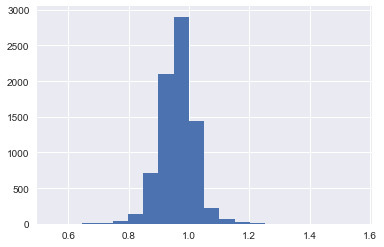

In [24]:
# r.hist(bins=20)

In [43]:
# sub_975.price_doc.sum() / y_predic_all_sq.sum()

1.0018019061255827

In [41]:
# y_predict_mod_2 = model.predict(dtest_subset)
# y_predic_all_sq = (y_predict_mod_2)*x_test_missing['full_sq']*0.975*0.96
# df_sub = pd.DataFrame({'id': test_id, 'price_doc': y_predic_all_sq})
# df_sub.to_csv('./sub_3_mod.csv', index=False)
# df_sub.head()

,id,price_doc
0,30474,5.458192e+06
1,30475,7.532280e+06
2,30476,5.288877e+06
3,30477,5.477155e+06
4,30478,4.706789e+06
